In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle

import torch
from torch.nn import CrossEntropyLoss, NLLLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN, inference_time, loadCIFAR10, plot_loss, plot_acc, plot_shifts, ASL_plot_acc, ASL_plot_loss

plt.rcParams['figure.dpi'] = 100

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100
input_shape = (batch_size, 3, 32, 32)
num_labels = 10

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadCIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


## ASL VGG

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/VGG/ASL_VGG_optimizer.pkl', 'rb') as file:
    ASL_VGG_optim = pickle.load(file)

best_parameters = ASL_VGG_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[1]

[{'acc': 82.592, 'lr': 0.05224609375, 'momentum': 0.78564453125, 'p_randomTransform': 0.0107421875}, {'acc': 79.078, 'lr': 0.08947506874612457, 'momentum': 0.5519628906250001, 'p_randomTransform': 0.6442425579588916}, {'acc': 78.9, 'lr': 0.10085937499999999, 'momentum': 0.6542951899242178, 'p_randomTransform': 0.5951562499999999}]


In [5]:
from Models import ASL_VGGNet

ASL_VGGNN = ASL_VGGNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, p_drop=0.2, expansion_rate=1)

summary(ASL_VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ASL_VGGNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─CSC_block: 2-3                    [100, 32, 32, 32]         --
│    │    └─Sequential: 3-1              --                        2,240
│    │    └─Identity: 3-2                [100, 32, 32, 32]         --
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─CSC_block: 2-7                    [100, 64, 16, 16]         --
│    │    └─Sequential: 3-3              --                        2,240
│    │    └─Conv2d: 3-4                  [100, 64, 16, 16]         2,112
│    

In [10]:
PATH = "models/VGG/ASL_VGGNet.pth"

if exists(PATH):
    ASL_VGGNN = torch.load(PATH)
    ASL_VGGNN.eval()

In [6]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(ASL_VGGNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2, device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 2.031
test_loss: 1.742, test_accuracy: 34.33
[1,   200] train_loss: 1.760
test_loss: 1.609, test_accuracy: 38.84
[1,   300] train_loss: 1.672
test_loss: 1.578, test_accuracy: 40.73
[1,   400] train_loss: 1.601
test_loss: 1.479, test_accuracy: 45.06
[1,   500] train_loss: 1.566
test_loss: 1.437, test_accuracy: 46.52
[2,   100] train_loss: 1.506
test_loss: 1.424, test_accuracy: 47.71
[2,   200] train_loss: 1.508
test_loss: 1.389, test_accuracy: 49.55
[2,   300] train_loss: 1.443
test_loss: 1.286, test_accuracy: 52.77
[2,   400] train_loss: 1.431
test_loss: 1.255, test_accuracy: 53.94
[2,   500] train_loss: 1.407
test_loss: 1.237, test_accuracy: 55.31
[3,   100] train_loss: 1.363
test_loss: 1.205, test_accuracy: 55.92
[3,   200] train_loss: 1.340
test_loss: 1.245, test_accuracy: 55.14
[3,   300] train_loss: 1.328
test_loss: 1.172, test_accuracy: 58.06
[3,   400] train_loss: 1.316
test_loss: 1.126, test_accuracy: 59.53
[3,   500] train_loss: 1.292
test_loss: 1.116, t

In [12]:
torch.save(ASL_VGGNN, "./models/VGG/ASL_VGGNet.pth")

In [4]:
ASL_VGGNN = torch.load("./models/VGG/ASL_VGGNet.pth")

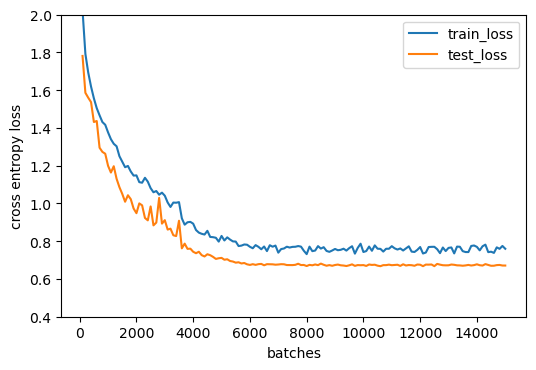

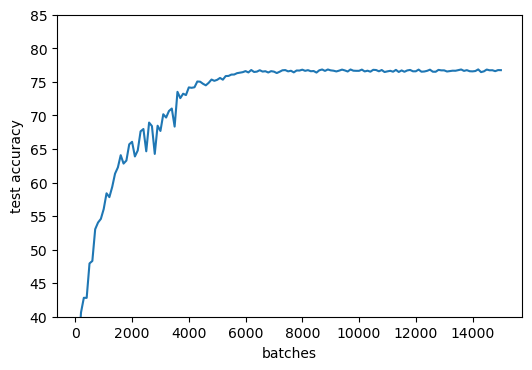

In [9]:
plot_loss(ASL_VGGNN, y_lim=(0.4, 2))
plot_acc(ASL_VGGNN, y_lim=(40, 85))

In [5]:
print("Training time (s):")
print(f"mean: {round(np.mean(ASL_VGGNN.train_time), 3)}")
print(f"std: {round(np.std(ASL_VGGNN.train_time), 3)}")

Training time (s):
mean: 6.924
std: 0.4


## ASL VGG RES2

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/VGG/ASL_VGG_optimizer.pkl', 'rb') as file:
    ASL_VGG_optim = pickle.load(file)

best_parameters = ASL_VGG_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[1]

[{'acc': 82.592, 'lr': 0.05224609375, 'momentum': 0.78564453125, 'p_randomTransform': 0.0107421875}, {'acc': 79.078, 'lr': 0.08947506874612457, 'momentum': 0.5519628906250001, 'p_randomTransform': 0.6442425579588916}, {'acc': 78.9, 'lr': 0.10085937499999999, 'momentum': 0.6542951899242178, 'p_randomTransform': 0.5951562499999999}]


In [5]:
from Models import ASL_VGGNet

ASL_VGGNN = ASL_VGGNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, p_drop=0.2, expansion_rate=1)

summary(ASL_VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ASL_VGGNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─CSC_block: 2-3                    [100, 32, 32, 32]         --
│    │    └─Sequential: 3-1              --                        2,240
│    │    └─Conv2d: 3-2                  [100, 32, 32, 32]         2,080
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─CSC_block: 2-7                    [100, 64, 16, 16]         --
│    │    └─Sequential: 3-3              --                        3,296
│    │    └─Conv2d: 3-4                  [100, 64, 16, 16]         6,208
│ 

In [6]:
PATH = "models/VGG/ASL_VGGNet_res2.pth"

if exists(PATH):
    ASL_VGGNN = torch.load(PATH)
    ASL_VGGNN.eval()

In [7]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(ASL_VGGNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2, device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 2.139
test_loss: 1.930, test_accuracy: 27.77
[1,   200] train_loss: 1.851
test_loss: 1.676, test_accuracy: 37.96
[1,   300] train_loss: 1.724
test_loss: 1.619, test_accuracy: 38.95
[1,   400] train_loss: 1.652
test_loss: 1.551, test_accuracy: 41.54
[1,   500] train_loss: 1.574
test_loss: 1.421, test_accuracy: 46.11
[2,   100] train_loss: 1.530
test_loss: 1.450, test_accuracy: 46.37
[2,   200] train_loss: 1.485
test_loss: 1.350, test_accuracy: 50.31
[2,   300] train_loss: 1.481
test_loss: 1.390, test_accuracy: 48.74
[2,   400] train_loss: 1.462
test_loss: 1.341, test_accuracy: 50.75
[2,   500] train_loss: 1.411
test_loss: 1.292, test_accuracy: 52.93
[3,   100] train_loss: 1.393
test_loss: 1.243, test_accuracy: 54.92
[3,   200] train_loss: 1.378
test_loss: 1.254, test_accuracy: 54.79
[3,   300] train_loss: 1.334
test_loss: 1.286, test_accuracy: 52.92
[3,   400] train_loss: 1.311
test_loss: 1.225, test_accuracy: 55.65
[3,   500] train_loss: 1.307
test_loss: 1.221, t

In [8]:
torch.save(ASL_VGGNN, "./models/VGG/ASL_VGGNet_res2.pth")

In [26]:
ASL_VGGNN = torch.load("./models/VGG/ASL_VGGNet_res2.pth")

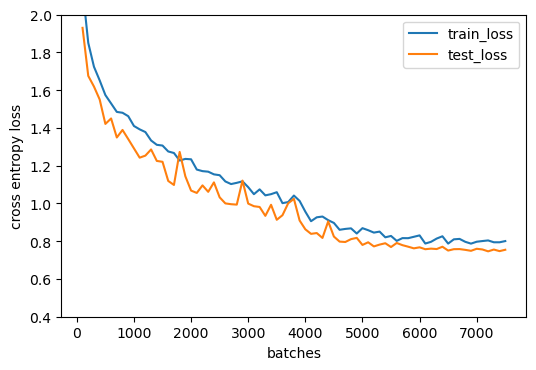

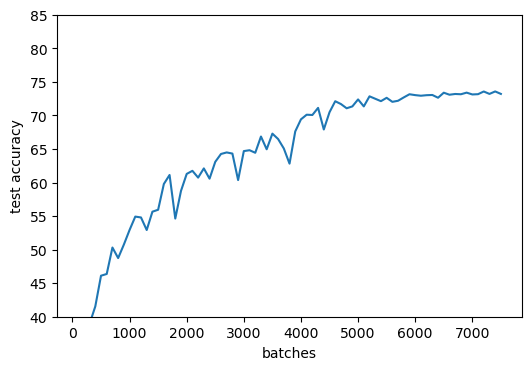

In [16]:
plot_loss(ASL_VGGNN, y_lim=(0.4, 2))
plot_acc(ASL_VGGNN, y_lim=(40, 85))

In [27]:
print("Training time (s):")
print(f"mean: {round(np.mean(ASL_VGGNN.train_time), 3)}")
print(f"std: {round(np.std(ASL_VGGNN.train_time), 3)}")

Training time (s):
mean: 8.628
std: 0.396


In [28]:
inference_times = inference_time(ASL_VGGNN, input_shape=(100, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
2.798e+01
3.0e-01


## ASL VGG res 3

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/VGG/ASL_VGG_optimizer.pkl', 'rb') as file:
    ASL_VGG_optim = pickle.load(file)

best_parameters = ASL_VGG_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[1]

[{'acc': 82.592, 'lr': 0.05224609375, 'momentum': 0.78564453125, 'p_randomTransform': 0.0107421875}, {'acc': 79.078, 'lr': 0.08947506874612457, 'momentum': 0.5519628906250001, 'p_randomTransform': 0.6442425579588916}, {'acc': 78.9, 'lr': 0.10085937499999999, 'momentum': 0.6542951899242178, 'p_randomTransform': 0.5951562499999999}]


In [7]:
from Models import ASL_VGGNet

ASL_VGGNN = ASL_VGGNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, p_drop=0.2, expansion_rate=1)

summary(ASL_VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ASL_VGGNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─CSC_block: 2-3                    [100, 32, 32, 32]         --
│    │    └─Sequential: 3-1              --                        1,184
│    │    └─Conv2d: 3-2                  [100, 32, 32, 32]         2,080
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─CSC_block: 2-7                    [100, 64, 16, 16]         --
│    │    └─Sequential: 3-3              --                        1,184
│    │    └─Conv2d: 3-4                  [100, 64, 16, 16]         4,160
│ 

In [6]:
PATH = "models/VGG/ASL_VGGNet_res3.pth"

if exists(PATH):
    ASL_VGGNN = torch.load(PATH)
    ASL_VGGNN.eval()

In [8]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(ASL_VGGNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2, device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 2.049
test_loss: 1.864, test_accuracy: 28.13
[1,   200] train_loss: 1.779
test_loss: 1.660, test_accuracy: 39.59
[1,   300] train_loss: 1.668
test_loss: 1.542, test_accuracy: 42.57
[1,   400] train_loss: 1.611
test_loss: 1.603, test_accuracy: 40.87
[1,   500] train_loss: 1.537
test_loss: 1.418, test_accuracy: 46.98
[2,   100] train_loss: 1.503
test_loss: 1.372, test_accuracy: 50.41
[2,   200] train_loss: 1.484
test_loss: 1.308, test_accuracy: 52.21
[2,   300] train_loss: 1.432
test_loss: 1.328, test_accuracy: 51.36
[2,   400] train_loss: 1.391
test_loss: 1.262, test_accuracy: 53.51
[2,   500] train_loss: 1.389
test_loss: 1.259, test_accuracy: 54.11
[3,   100] train_loss: 1.350
test_loss: 1.201, test_accuracy: 56.56
[3,   200] train_loss: 1.332
test_loss: 1.202, test_accuracy: 56.49
[3,   300] train_loss: 1.292
test_loss: 1.122, test_accuracy: 59.82
[3,   400] train_loss: 1.273
test_loss: 1.154, test_accuracy: 58.49
[3,   500] train_loss: 1.260
test_loss: 1.120, t

In [10]:
torch.save(ASL_VGGNN, "./models/VGG/ASL_VGGNet_res3.pth")

In [11]:
ASL_VGGNN = torch.load("./models/VGG/ASL_VGGNet_res3.pth")

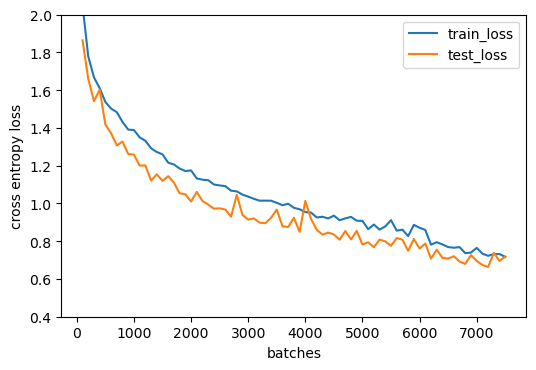

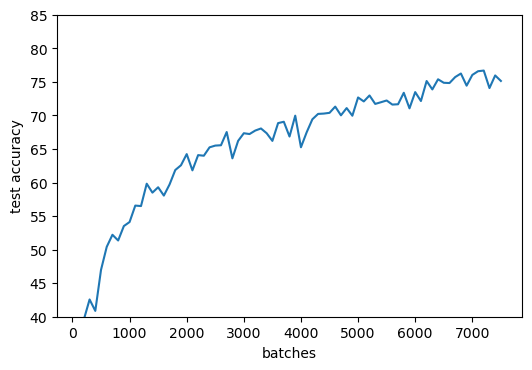

In [12]:
plot_loss(ASL_VGGNN, y_lim=(0.4, 2))
plot_acc(ASL_VGGNN, y_lim=(40, 85))

In [13]:
print("Training time (s):")
print(f"mean: {round(np.mean(ASL_VGGNN.train_time), 3)}")
print(f"std: {round(np.std(ASL_VGGNN.train_time), 3)}")

Training time (s):
mean: 7.112
std: 0.398


In [14]:
inference_times = inference_time(ASL_VGGNN, input_shape=(100, 3, 32, 32), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
2.459e+01
6.0e-01
